## Import Libraries and Read Data

In [3599]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import seaborn as sns
import joblib
import statsmodels.stats.api as sms

# Define color palette
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
data = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration

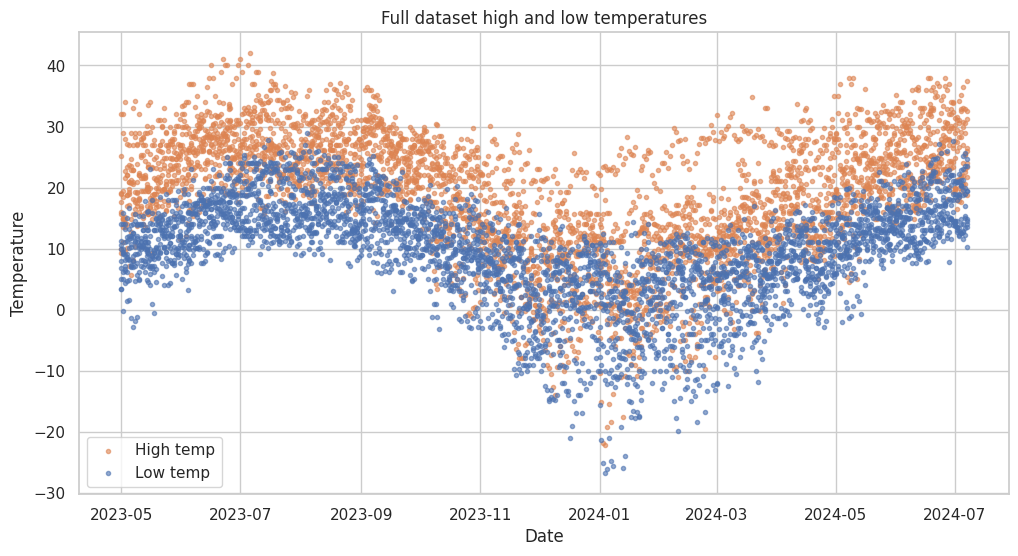

In [3600]:
# Plot the tempmax and tempmin columns
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(data.index, data['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(data.index, data['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [3601]:
print(data.shape)
data.isnull().sum()

(3906, 27)


location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [3602]:
data.duplicated().sum()

0

In [3603]:
# Drop Columns of No Interest
df = data.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

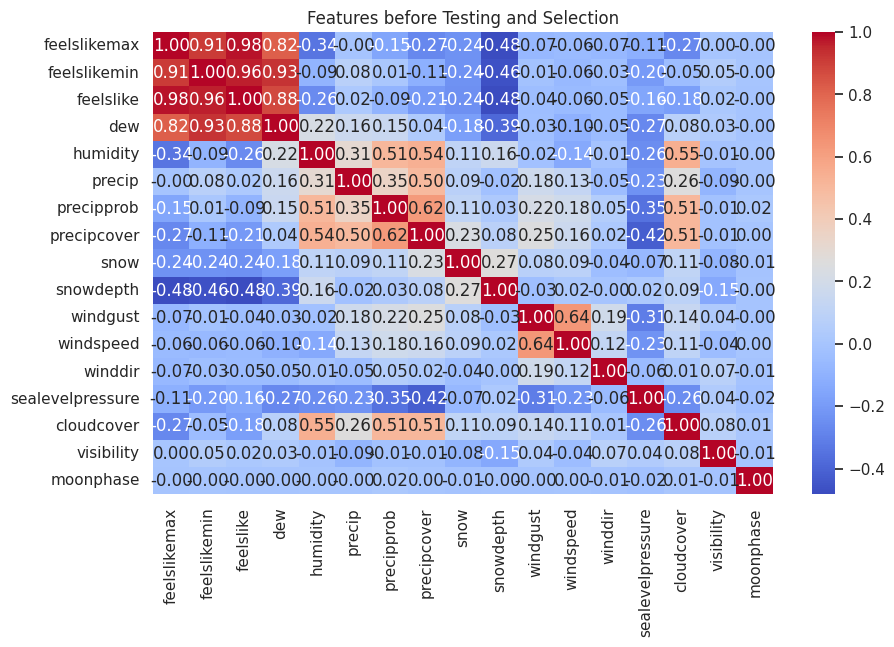

In [3604]:
all_features = df[['feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

df = df.select_dtypes(include=['number'])
correlation_matrix = all_features.corr()
plt.figure(figsize=(10, 6))
plt.title("Features before Testing and Selection")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## Feature Selection and Engineering

In [3605]:
# Define the DataFrame with combined highly correlated features for tempmax and tempmin
df['feelslike_max_combined'] = df[['feelslikemax', 'feelslike']].mean(axis=1)
df['feelslike_min_combined'] = df[['feelslikemin', 'feelslike']].mean(axis=1)
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

# Recalculate the features DataFrame without the original features tempmax
features_combined_max = df[['feelslike_max_combined', 'dew_humidity', 'snow']]

# Recalculate the features DataFrame without the original features tempmin
features_combined_min = df[['feelslike_min_combined', 'dew_humidity', 'precipprob']]


In [3606]:
# Create lagged variables for tempmax features
df['feelslike_max_combined_lag1'] = df['feelslike_max_combined'].shift(1)
df['dew_humidity_lag1'] = df['dew_humidity'].shift(1)
df['snow_lag1'] = df['snow'].shift(1)

# Create lagged variables for tempmin features
df['dew_humidity_lag1'] = df['dew_humidity'].shift(1)
df['dew_humidity_lag4'] = df['dew_humidity'].shift(4)
df['dew_humidity_lag6'] = df['dew_humidity'].shift(6)
df['dew_humidity_lag10'] = df['dew_humidity'].shift(10)
df['dew_humidity_lag19'] = df['dew_humidity'].shift(19)
df['dew_humidity_lag24'] = df['dew_humidity'].shift(24)

df['snowdepth_lag1'] = df['snowdepth'].shift(1)
df['visibility_lag1'] = df['visibility'].shift(1)
# Drop rows with missing values caused by lagging
df.dropna(inplace=True)

# Combine most important lagged values by taking the mean
df['feelslike_max_combined_lags'] = df[['feelslike_max_combined', 'feelslike_max_combined_lag1']].mean(axis=1)
df['snow_lags'] = df[['snow', 'snow_lag1']].mean(axis=1)
df['dew_humidity_lags'] = df[['dew_humidity', 'dew_humidity_lag1']].mean(axis=1)
df['snowdepth_lags'] = df[['snowdepth', 'snowdepth_lag1']].mean(axis=1)
df['visibility_lags'] = df[['visibility', 'visibility_lag1']].mean(axis=1)

df['dew_humidity_combined_lags'] = df[['dew_humidity',
    'dew_humidity_lag1', 'dew_humidity_lag4','dew_humidity_lag6', 'dew_humidity_lag10', 'dew_humidity_lag19', 'dew_humidity_lag24']].mean(axis=1)


# Recalculate the features DataFrame with lagged variables for tempmax
features_combined_max = df[['feelslike_max_combined_lags',
                            'dew_humidity',
                            'snow_lags',
                            'snowdepth_lags']]

# Recalculate the features DataFrame with lagged variables for tempmin
features_combined_min = df[['feelslike_min_combined',
                            'dew_humidity_combined_lags',
                            'precipprob']]


In [3607]:
# Define target variables
y_max = df['tempmax']
y_min = df['tempmin']

# Initialize empty list to store features
X_max = features_combined_max.columns.tolist()
X_min = features_combined_min.columns.tolist()


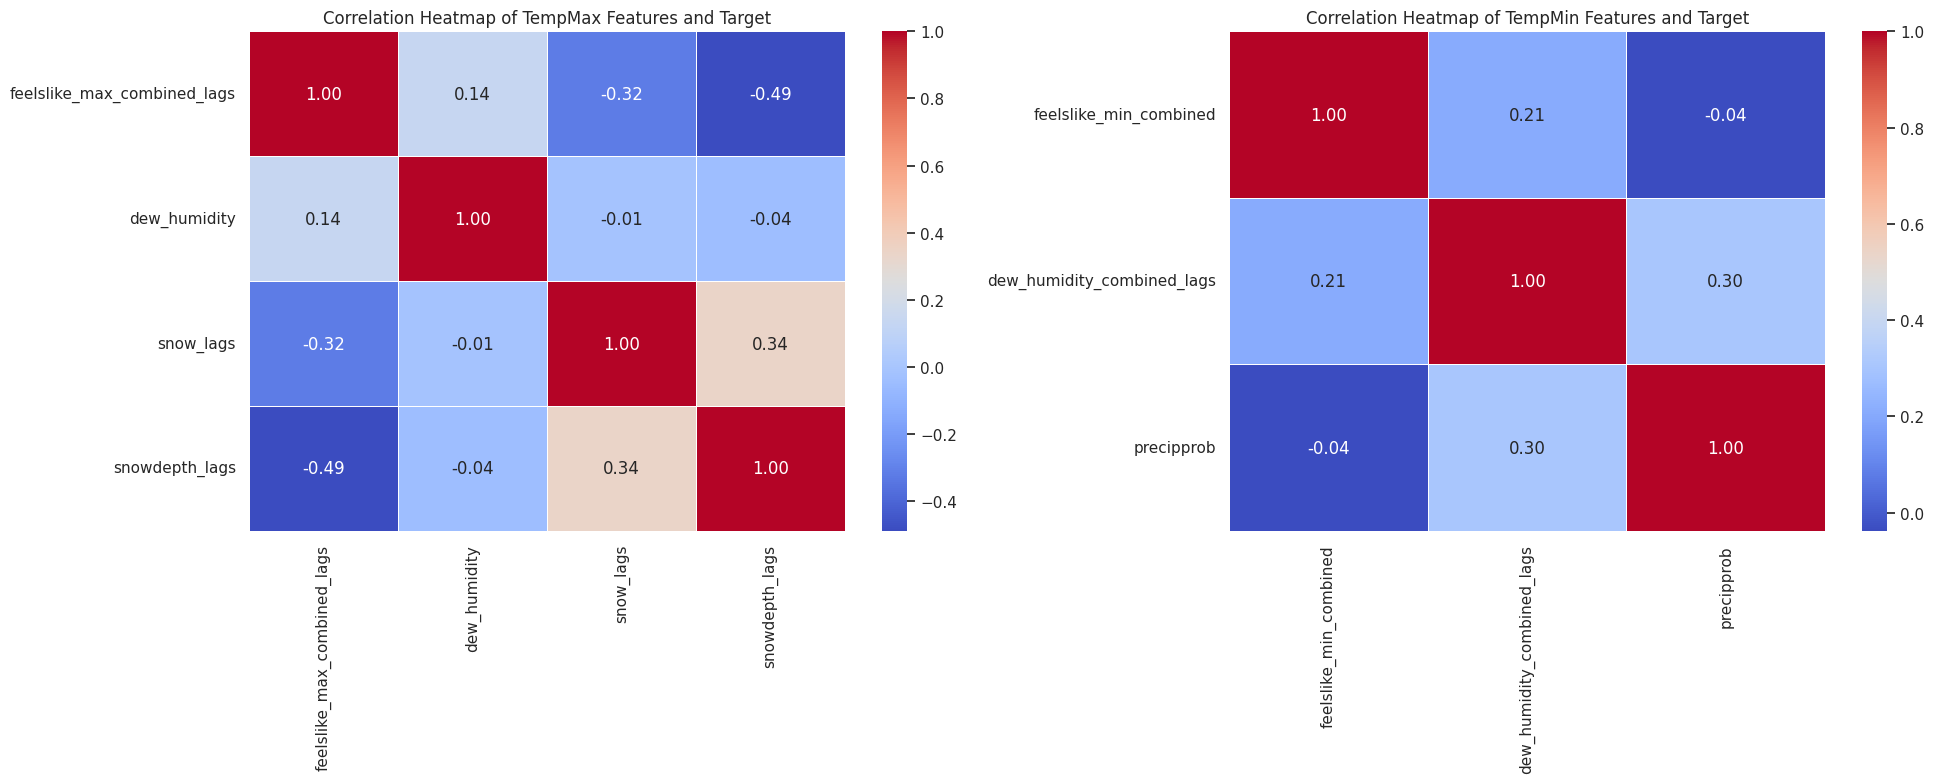

In [3608]:
matrix_max = features_combined_max.corr()
matrix_min = features_combined_min.corr()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot heatmap for TempMax
sns.heatmap(matrix_max, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap of TempMax Features and Target')

# Plot heatmap for TempMin
sns.heatmap(matrix_min, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap of TempMin Features and Target')

plt.tight_layout()
plt.show()

In [3609]:
""" Addressing Multicollinearity with Variance Inflation Factor"""
# Calculate VIF for each feature in tempmax
vif_data_max = pd.DataFrame()
vif_data_max["tempmax feature"] = features_combined_max.columns
vif_data_max["VIF"] = [variance_inflation_factor(features_combined_max.values, i) for i in range(features_combined_max.shape[1])]

# Calculate VIF for each feature in tempmin
vif_data_min = pd.DataFrame()
vif_data_min["tempmin feature"] = features_combined_min.columns
vif_data_min["VIF"] = [variance_inflation_factor(features_combined_min.values, i) for i in range(features_combined_min.shape[1])]

               tempmax feature       VIF
0  feelslike_max_combined_lags  4.142747
1                 dew_humidity  4.283876
2                    snow_lags  1.190707
3               snowdepth_lags  1.383131
              tempmin feature       VIF
0      feelslike_min_combined  2.285466
1  dew_humidity_combined_lags  3.693368
2                  precipprob  2.170403


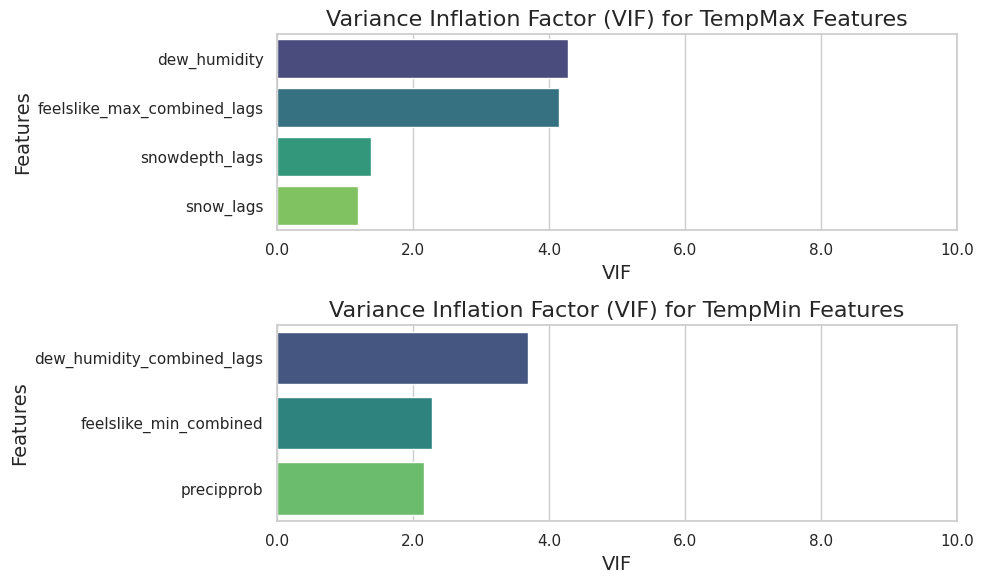

In [3610]:
print(vif_data_max)
print(vif_data_min)

# Plotting the VIF results for tempmax and tempmin as subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
sns.set(style="whitegrid")

# VIF for TempMax Features
sns.barplot(x="VIF", y="tempmax feature", hue="tempmax feature", dodge=False, data=vif_data_max.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[0], legend=False)
axes[0].set_title('Variance Inflation Factor (VIF) for TempMax Features', fontsize=16)
axes[0].set_xlabel('VIF', fontsize=14)
axes[0].set_ylabel('Features', fontsize=14)
axes[0].set_xlim(0, 10)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# VIF for TempMin Features
sns.barplot(x="VIF", y="tempmin feature", hue="tempmin feature", dodge=False, data=vif_data_min.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[1], legend=False)
axes[1].set_title('Variance Inflation Factor (VIF) for TempMin Features', fontsize=16)
axes[1].set_xlabel('VIF', fontsize=14)
axes[1].set_ylabel('Features', fontsize=14)
axes[1].set_xlim(0, 10)
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Adjust layout
plt.tight_layout()
plt.show()

## Data Splitting - Train/Validate/Test

In [3611]:
# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

# Split the data into before and after the split date
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

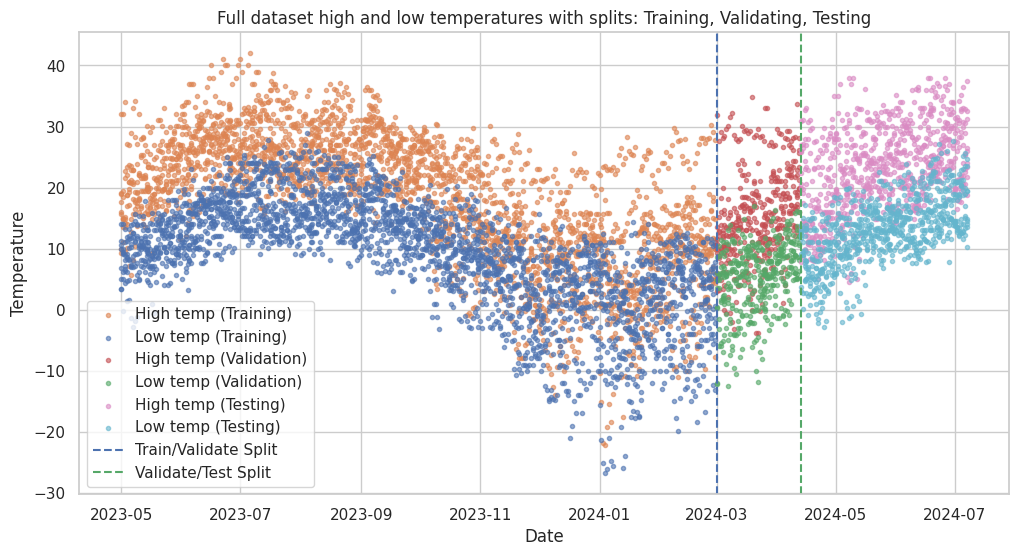

In [3612]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the tempmax and tempmin columns for training data
plt.scatter(train.index, train['tempmax'], color=color_pal[1], label='High temp (Training)', alpha=0.6, marker='.')
plt.scatter(train.index, train['tempmin'], color=color_pal[0], label='Low temp (Training)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for validation data
plt.scatter(validate.index, validate['tempmax'], color=color_pal[3], label='High temp (Validation)', alpha=0.6, marker='.')
plt.scatter(validate.index, validate['tempmin'], color=color_pal[2], label='Low temp (Validation)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for testing data
plt.scatter(test.index, test['tempmax'], color=color_pal[6], label='High temp (Testing)', alpha=0.6, marker='.')
plt.scatter(test.index, test['tempmin'], color=color_pal[9], label='Low temp (Testing)', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures with splits: Training, Validating, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[0], ls='--', label='Train/Validate Split')
ax.axvline(validate_end_date, color=color_pal[2], ls='--', label='Validate/Test Split')

# Add legend
plt.legend()

# Show the plot
plt.show()

## Define Target Variables and Feature Sets

In [3613]:
# Define target variables
y_train_max = train['tempmax']
y_train_min = train['tempmin']
y_val_max = validate['tempmax']
y_val_min = validate['tempmin']
y_test_max = test['tempmax']
y_test_min = test['tempmin']

# Define feature sets tempmax
X_train_max = train[X_max]
X_val_max = validate[X_max]
X_test_max = test[X_max]

# Define feature sets tempmin
X_train_min = train[X_min]
X_val_min = validate[X_min]
X_test_min = test[X_min]

## Model Training and Evaluation

In [3614]:
# Robust scaling the feature variables
scaler_max = RobustScaler()
scaler_min = RobustScaler()

# Fit and transform the training data with scaler
X_train_max_scaled = scaler_max.fit_transform(X_train_max)
X_train_min_scaled = scaler_min.fit_transform(X_train_min)

# Transform the validation data using the same scaler
X_val_max_scaled = scaler_max.transform(X_val_max)
X_val_min_scaled = scaler_min.transform(X_val_min)

# Hyperparameter tuning using GridSearchCV for Ridge Regression
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# GridSearchCV for tempmax
ridge_max = Ridge()
grid_search_max = GridSearchCV(ridge_max, param_grid, cv=5, scoring='r2')
grid_search_max.fit(X_train_max_scaled, y_train_max)
best_alpha_max = grid_search_max.best_params_['alpha']

# GridSearchCV for tempmin
ridge_min = Ridge()
grid_search_min = GridSearchCV(ridge_min, param_grid, cv=5, scoring='r2')
grid_search_min.fit(X_train_min_scaled, y_train_min)
best_alpha_min = grid_search_min.best_params_['alpha']

# Initialize and fit the Ridge Regression model with best alpha for tempmax
ridge_model_max = Ridge(alpha=best_alpha_max)
ridge_model_max.fit(X_train_max_scaled, y_train_max)

# Make predictions on the validation set for tempmax
y_pred_val_max = ridge_model_max.predict(X_val_max_scaled)

# Calculate R² for validation set for tempmax
r2_val_max = r2_score(y_val_max, y_pred_val_max)
print(f"Ridge Regression Validate R² for tempmax (1): {r2_val_max}")

# Initialize and fit the Ridge Regression model with best alpha for tempmin
ridge_model_min = Ridge(alpha=best_alpha_min)
ridge_model_min.fit(X_train_min_scaled, y_train_min)

# Make predictions on the validation set for tempmin
y_pred_val_min = ridge_model_min.predict(X_val_min_scaled)

# Calculate R² for validation set for tempmin
r2_val_min = r2_score(y_val_min, y_pred_val_min)
print(f"Ridge Regression Validate R² for tempmin (1): {r2_val_min}")

# Calculate residuals
residuals_max = y_val_max - y_pred_val_max
residuals_min = y_val_min - y_pred_val_min

# Calculate RMSE for TempMax Ridge
rmse_max = np.sqrt(mean_squared_error(y_val_max, y_pred_val_max))
print(f'RMSE for Ridge TempMax (0): {rmse_max}')

# Calculate RMSE for TempMin Ridge
rmse_min = np.sqrt(mean_squared_error(y_val_min, y_pred_val_min))
print(f'RMSE for Ridge TempMin (0): {rmse_min}')

# Compute Durbin-Watson statistic
dw_stat_max = durbin_watson(residuals_max)
dw_stat_min = durbin_watson(residuals_min)

print(f'Durbin-Watson Statistic for TempMax Residuals (2): {dw_stat_max}')
print(f'Durbin-Watson Statistic for TempMin Residuals (2): {dw_stat_min}')

Ridge Regression Validate R² for tempmax (1): 0.9266886842210523
Ridge Regression Validate R² for tempmin (1): 0.9344312910276247
RMSE for Ridge TempMax (0): 2.0211792489654528
RMSE for Ridge TempMin (0): 1.4362800879823043
Durbin-Watson Statistic for TempMax Residuals (2): 1.7785190698593736
Durbin-Watson Statistic for TempMin Residuals (2): 1.3376822351561288


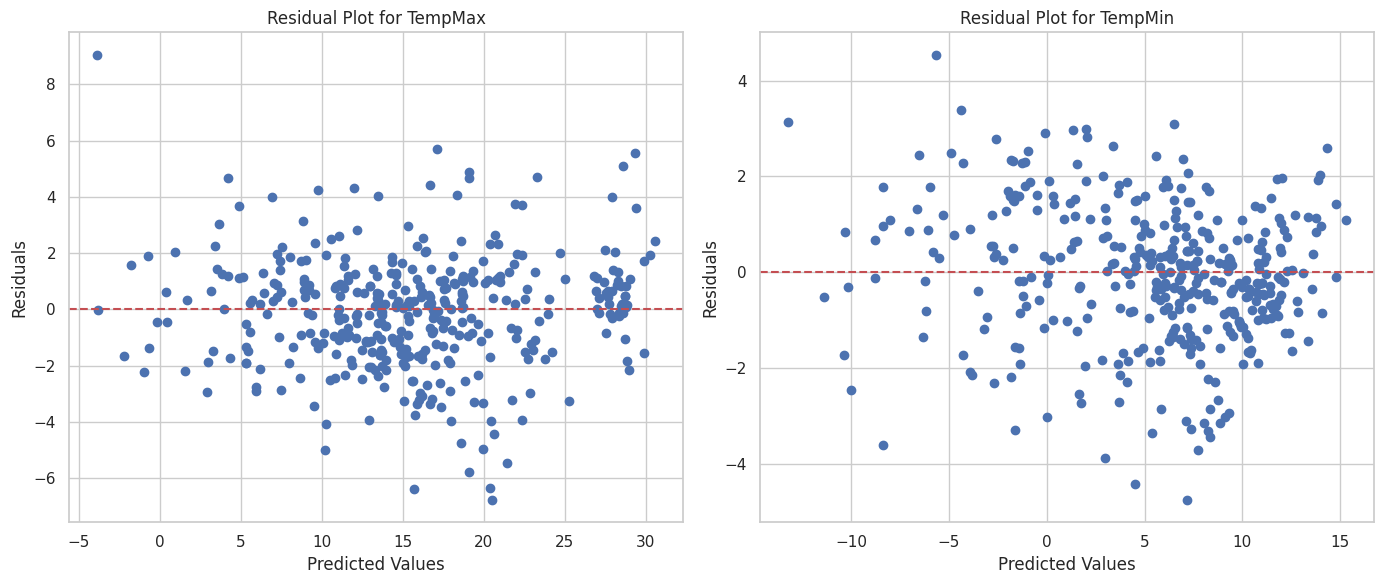

In [3615]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residual plots for TempMax
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_val_max, residuals_max)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for TempMax')

# Residual plots for TempMin
plt.subplot(1, 2, 2)
plt.scatter(y_pred_val_min, residuals_min)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for TempMin')

plt.tight_layout()
plt.show()


In [3616]:
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.stattools import durbin_watson

# Transform the testing data using the same scaler
X_test_max_scaled = scaler_max.transform(X_test_max)
X_test_min_scaled = scaler_min.transform(X_test_min)

# Fit the Ridge Regression model with best alpha for TempMax on combined train + val
ridge_model_max.fit(np.vstack([X_train_max_scaled, X_val_max_scaled]),
                    np.concatenate([y_train_max, y_val_max]))

# Make predictions on the testing set for TempMax
y_pred_test_max = ridge_model_max.predict(X_test_max_scaled)

# Calculate R² for testing set for TempMax
r2_test_max = r2_score(y_test_max, y_pred_test_max)
print(f"Ridge Regression Test R² for TempMax: {r2_test_max}")

# Calculate RMSE for TempMax Ridge
rmse_test_max = np.sqrt(mean_squared_error(y_test_max, y_pred_test_max))
print(f'RMSE for Ridge TempMax: {rmse_test_max}')

# Fit the Ridge Regression model with best alpha for TempMin on combined train + val
ridge_model_min.fit(np.vstack([X_train_min_scaled, X_val_min_scaled]),
                    np.concatenate([y_train_min, y_val_min]))

# Make predictions on the testing set for TempMin
y_pred_test_min = ridge_model_min.predict(X_test_min_scaled)

# Calculate R² for testing set for TempMin
r2_test_min = r2_score(y_test_min, y_pred_test_min)
print(f"Ridge Regression Test R² for TempMin: {r2_test_min}")

# Calculate RMSE for TempMin Ridge
rmse_test_min = np.sqrt(mean_squared_error(y_test_min, y_pred_test_min))
print(f'RMSE for Ridge TempMin: {rmse_test_min}')

# Calculate residuals
residuals_test_max = y_test_max - y_pred_test_max
residuals_test_min = y_test_min - y_pred_test_min

# Compute Durbin-Watson statistic for testing data residuals
dw_stat_test_max = durbin_watson(residuals_test_max)
dw_stat_test_min = durbin_watson(residuals_test_min)

print(f'Durbin-Watson Statistic for TempMax Test Residuals: {dw_stat_test_max}')
print(f'Durbin-Watson Statistic for TempMin Test Residuals: {dw_stat_test_min}')


Ridge Regression Test R² for TempMax: 0.9135357262661321
RMSE for Ridge TempMax: 1.9787319066085682
Ridge Regression Test R² for TempMin: 0.9438229664571264
RMSE for Ridge TempMin: 1.238933406151896
Durbin-Watson Statistic for TempMax Test Residuals: 1.6970698155437782
Durbin-Watson Statistic for TempMin Test Residuals: 1.2966050458489229


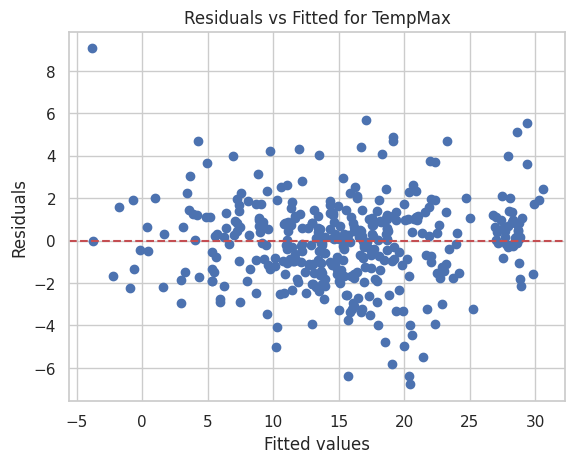

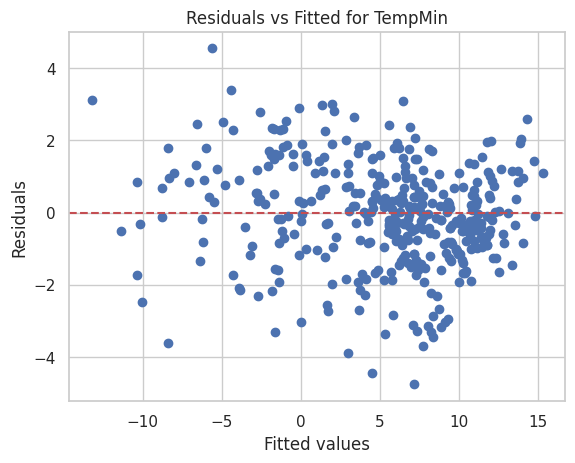

Durbin-Watson Statistic for TempMax Residuals: 1.7785190698593736
Durbin-Watson Statistic for TempMin Residuals: 1.3376822351561288
Breusch-Pagan Test for TempMax: {'Lagrange multiplier statistic': 0.0852355727619587, 'p-value': 0.7703238448238516, 'f-value': 0.08481375881827512, 'f p-value': 0.771033768898635}
Breusch-Pagan Test for TempMin: {'Lagrange multiplier statistic': 12.690209963932844, 'p-value': 0.00036757499433779533, 'f-value': 13.05263972829398, 'f p-value': 0.0003429993473399007}
Breusch-Pagan Test for TempMax: {'Lagrange multiplier statistic': 0.0852355727619587, 'p-value': 0.7703238448238516, 'f-value': 0.08481375881827512, 'f p-value': 0.771033768898635}
Breusch-Pagan Test for TempMin: {'Lagrange multiplier statistic': 12.690209963932844, 'p-value': 0.00036757499433779533, 'f-value': 13.05263972829398, 'f p-value': 0.0003429993473399007}
Shapiro-Wilk Test for TempMax Residuals: W=0.9802328631942862, p-value=3.832338111601172e-05
Shapiro-Wilk Test for TempMin Residuals

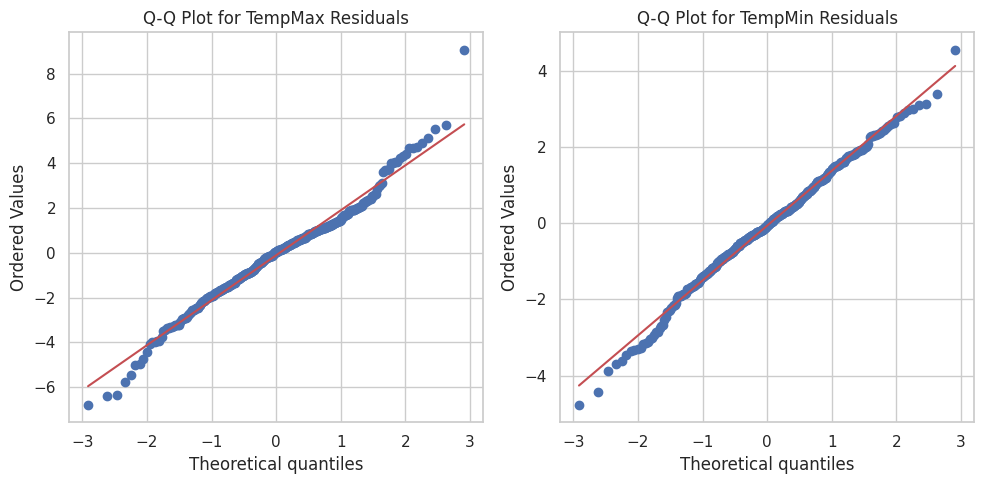

VIF for TempMax Features: 
                       feature       VIF
0  feelslike_max_combined_lags  1.535323
1                 dew_humidity  1.068527
2                    snow_lags  1.249406
3               snowdepth_lags  1.521595
VIF for TempMin Features: 
                      feature       VIF
0      feelslike_min_combined  1.169046
1  dew_humidity_combined_lags  1.134503
2                  precipprob  1.054655


In [3617]:
import matplotlib.pyplot as plt

plt.scatter(y_pred_val_max, residuals_max)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted for TempMax')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

plt.scatter(y_pred_val_min, residuals_min)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted for TempMin')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()
from statsmodels.stats.stattools import durbin_watson

dw_stat_max = durbin_watson(residuals_max)
dw_stat_min = durbin_watson(residuals_min)

print(f'Durbin-Watson Statistic for TempMax Residuals: {dw_stat_max}')
print(f'Durbin-Watson Statistic for TempMin Residuals: {dw_stat_min}')
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import statsmodels.api as sm

# For TempMax
test_max = sm.OLS(residuals_max, sm.add_constant(y_pred_val_max)).fit()
bp_test_max = het_breuschpagan(test_max.resid, test_max.model.exog)
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
lzip(names, bp_test_max)
print(f'Breusch-Pagan Test for TempMax: {dict(lzip(names, bp_test_max))}')

# For TempMin
test_min = sm.OLS(residuals_min, sm.add_constant(y_pred_val_min)).fit()
bp_test_min = het_breuschpagan(test_min.resid, test_min.model.exog)
lzip(names, bp_test_min)
print(f'Breusch-Pagan Test for TempMin: {dict(lzip(names, bp_test_min))}')
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import statsmodels.api as sm

# For TempMax
test_max = sm.OLS(residuals_max, sm.add_constant(y_pred_val_max)).fit()
bp_test_max = het_breuschpagan(test_max.resid, test_max.model.exog)
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
lzip(names, bp_test_max)
print(f'Breusch-Pagan Test for TempMax: {dict(lzip(names, bp_test_max))}')

# For TempMin
test_min = sm.OLS(residuals_min, sm.add_constant(y_pred_val_min)).fit()
bp_test_min = het_breuschpagan(test_min.resid, test_min.model.exog)
lzip(names, bp_test_min)
print(f'Breusch-Pagan Test for TempMin: {dict(lzip(names, bp_test_min))}')

from scipy.stats import shapiro, probplot

# Shapiro-Wilk Test
shapiro_max = shapiro(residuals_max)
shapiro_min = shapiro(residuals_min)
print(f'Shapiro-Wilk Test for TempMax Residuals: W={shapiro_max[0]}, p-value={shapiro_max[1]}')
print(f'Shapiro-Wilk Test for TempMin Residuals: W={shapiro_min[0]}, p-value={shapiro_min[1]}')

# Q-Q Plot
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
probplot(residuals_max, dist="norm", plot=plt)
plt.title('Q-Q Plot for TempMax Residuals')

plt.subplot(1, 2, 2)
probplot(residuals_min, dist="norm", plot=plt)
plt.title('Q-Q Plot for TempMin Residuals')

plt.tight_layout()
plt.show()
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X_train_max_scaled and X_train_min_scaled are DataFrames
vif_data_max = pd.DataFrame()
vif_data_max["feature"] = X_train_max.columns
vif_data_max["VIF"] = [variance_inflation_factor(X_train_max_scaled, i) for i in range(X_train_max_scaled.shape[1])]

vif_data_min = pd.DataFrame()
vif_data_min["feature"] = X_train_min.columns
vif_data_min["VIF"] = [variance_inflation_factor(X_train_min_scaled, i) for i in range(X_train_min_scaled.shape[1])]

print(f'VIF for TempMax Features: \n{vif_data_max}')
print(f'VIF for TempMin Features: \n{vif_data_min}')


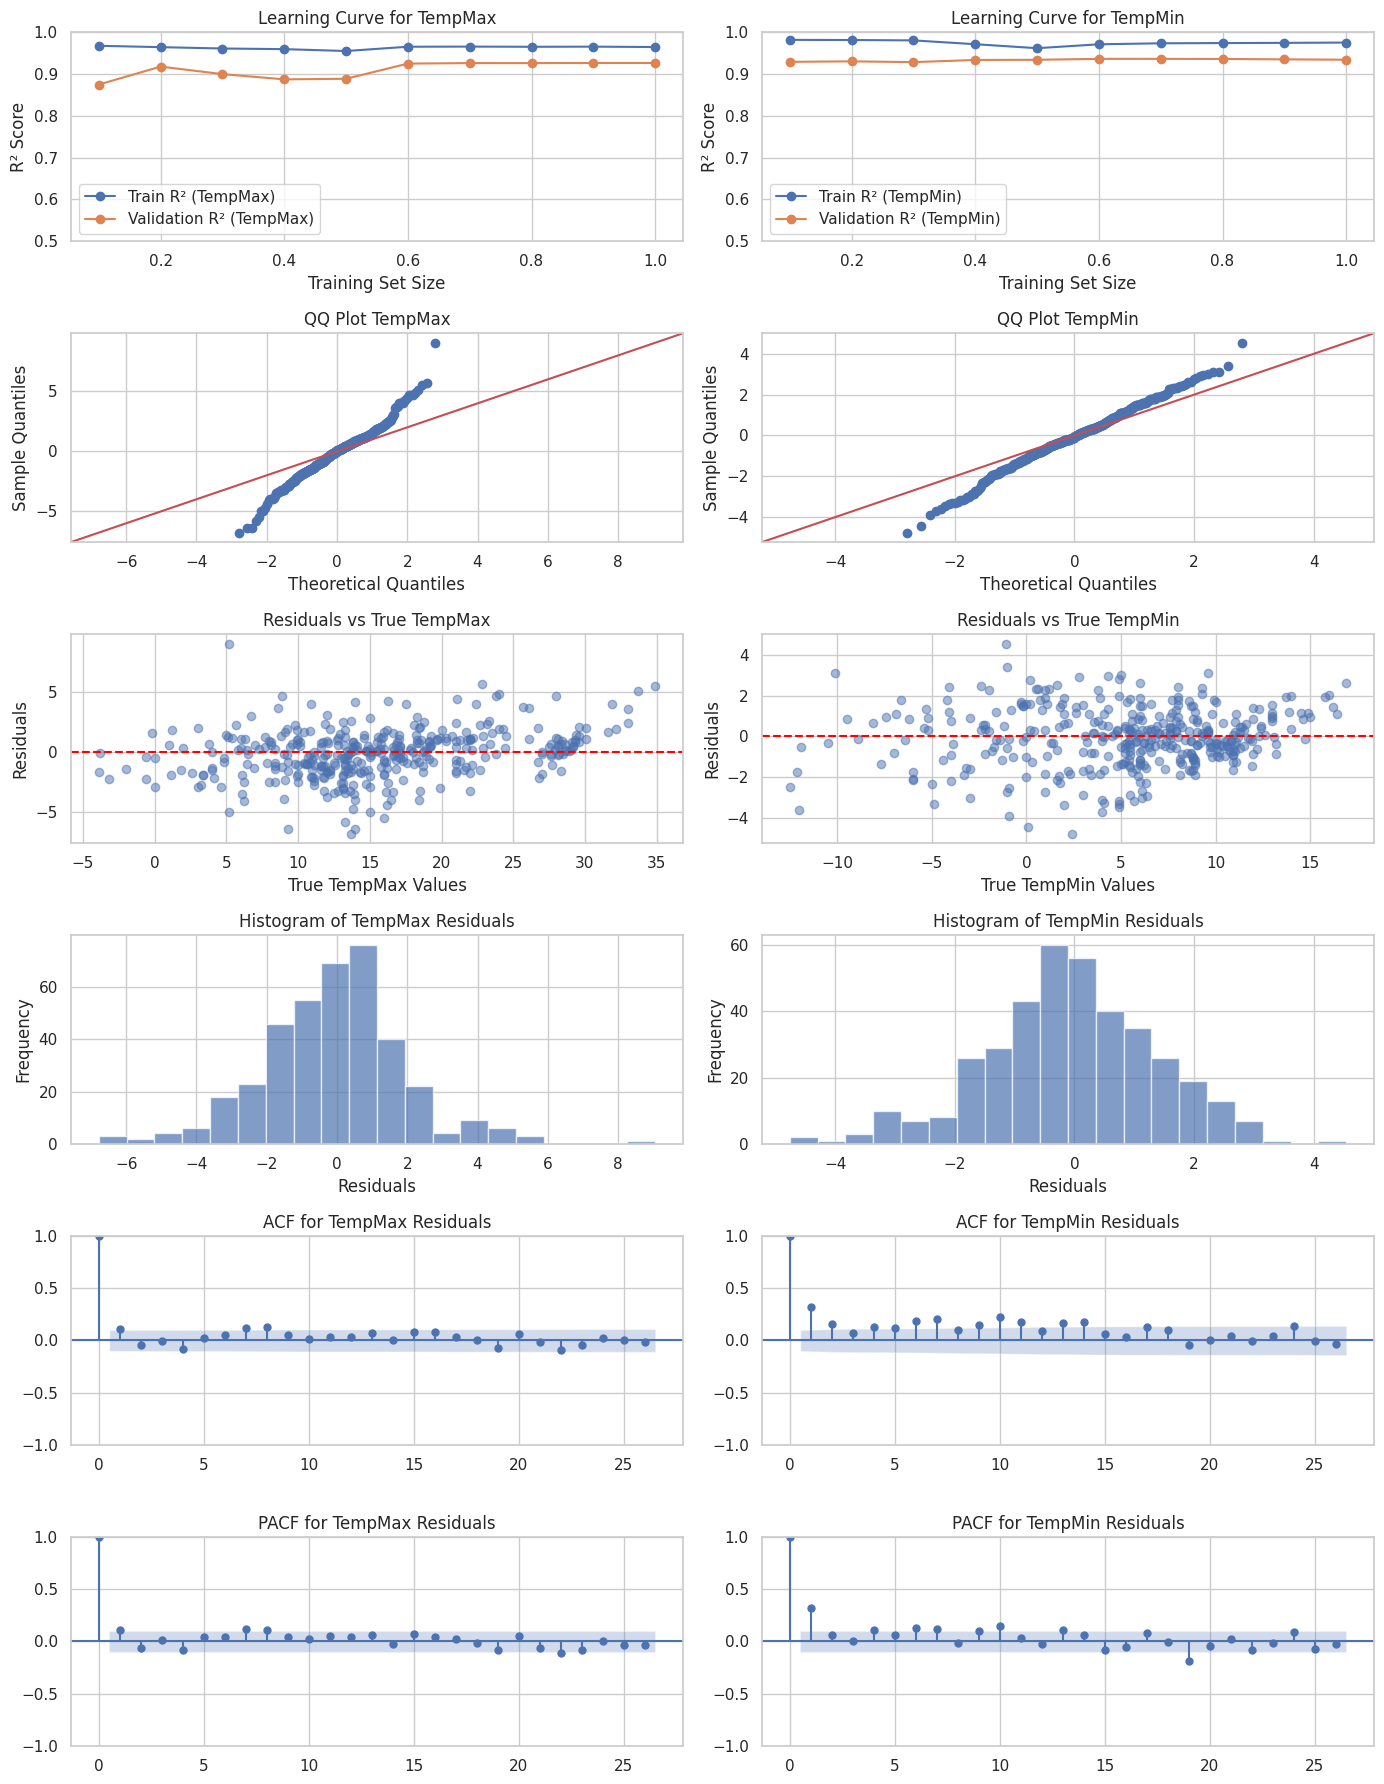

In [3618]:
# List to store results
train_sizes = np.linspace(0.1, 1.0, 10)
train_r2_max = []
val_r2_max = []
train_r2_min = []
val_r2_min = []

for train_size in train_sizes:
    # Calculate the number of samples for the current training subset size
    subset_size_max = int(train_size * len(X_train_max_scaled))
    subset_size_min = int(train_size * len(X_train_min_scaled))

    # Create training subsets
    X_train_max_subset = X_train_max_scaled[:subset_size_max]
    y_train_max_subset = y_train_max.iloc[:subset_size_max]

    X_train_min_subset = X_train_min_scaled[:subset_size_min]
    y_train_min_subset = y_train_min.iloc[:subset_size_min]

    # Initialize and fit the Ridge Regression model
    ridge_model_max = Ridge(alpha=best_alpha_max)
    ridge_model_max.fit(X_train_max_subset, y_train_max_subset)

    ridge_model_min = Ridge(alpha=best_alpha_min)
    ridge_model_min.fit(X_train_min_subset, y_train_min_subset)

    # Predict and evaluate
    y_train_pred_max = ridge_model_max.predict(X_train_max_subset)
    y_val_pred_max = ridge_model_max.predict(X_val_max_scaled)

    y_train_pred_min = ridge_model_min.predict(X_train_min_subset)
    y_val_pred_min = ridge_model_min.predict(X_val_min_scaled)

    # Compute R²
    train_r2_max.append(r2_score(y_train_max_subset, y_train_pred_max))
    val_r2_max.append(r2_score(y_val_max, y_val_pred_max))

    train_r2_min.append(r2_score(y_train_min_subset, y_train_pred_min))
    val_r2_min.append(r2_score(y_val_min, y_val_pred_min))

# Create subplots: 6 rows and 2 columns
fig, ax = plt.subplots(6, 2, figsize=(14, 18))  # Adjust the figsize for better spacing

# Learning Curve for TempMax
ax[0, 0].plot(train_sizes, train_r2_max, label='Train R² (TempMax)', marker='o')
ax[0, 0].plot(train_sizes, val_r2_max, label='Validation R² (TempMax)', marker='o')
ax[0, 0].set_title('Learning Curve for TempMax')
ax[0, 0].set_xlabel('Training Set Size')
ax[0, 0].set_ylabel('R² Score')
ax[0, 0].legend()
ax[0, 0].grid(True)
ax[0, 0].set_ylim(0.5, 1.0)  # Set y-axis limit for TempMax

# Learning Curve for TempMin
ax[0, 1].plot(train_sizes, train_r2_min, label='Train R² (TempMin)', marker='o')
ax[0, 1].plot(train_sizes, val_r2_min, label='Validation R² (TempMin)', marker='o')
ax[0, 1].set_title('Learning Curve for TempMin')
ax[0, 1].set_xlabel('Training Set Size')
ax[0, 1].set_ylabel('R² Score')
ax[0, 1].legend()
ax[0, 1].grid(True)
ax[0, 1].set_ylim(0.5, 1.0)  # Set y-axis limit for TempMin

# QQ Plot for TempMax
sm.qqplot(residuals_max, line='45', ax=ax[1, 0])
ax[1, 0].set_title('QQ Plot TempMax')

# QQ Plot for TempMin
sm.qqplot(residuals_min, line='45', ax=ax[1, 1])
ax[1, 1].set_title('QQ Plot TempMin')

# Scatter Plot for TempMax Residuals vs True Values
ax[2, 0].scatter(y_val_max, residuals_max, alpha=0.5)
ax[2, 0].axhline(0, color='red', linestyle='--')
ax[2, 0].set_xlabel('True TempMax Values')
ax[2, 0].set_ylabel('Residuals')
ax[2, 0].set_title('Residuals vs True TempMax')

# Scatter Plot for TempMin Residuals vs True Values
ax[2, 1].scatter(y_val_min, residuals_min, alpha=0.5)
ax[2, 1].axhline(0, color='red', linestyle='--')
ax[2, 1].set_xlabel('True TempMin Values')
ax[2, 1].set_ylabel('Residuals')
ax[2, 1].set_title('Residuals vs True TempMin')

# Histogram of TempMax Residuals
ax[3, 0].hist(residuals_max, bins=20, alpha=0.7)
ax[3, 0].set_title('Histogram of TempMax Residuals')
ax[3, 0].set_xlabel('Residuals')
ax[3, 0].set_ylabel('Frequency')

# Histogram of TempMin Residuals
ax[3, 1].hist(residuals_min, bins=20, alpha=0.7)
ax[3, 1].set_title('Histogram of TempMin Residuals')
ax[3, 1].set_xlabel('Residuals')
ax[3, 1].set_ylabel('Frequency')

# ACF for TempMax Residuals
plot_acf(residuals_max, ax=ax[4, 0])
ax[4, 0].set_title('ACF for TempMax Residuals')

# ACF for TempMin Residuals
plot_acf(residuals_min, ax=ax[4, 1])
ax[4, 1].set_title('ACF for TempMin Residuals')

# PACF for TempMax Residuals
plot_pacf(residuals_max, ax=ax[5, 0])
ax[5, 0].set_title('PACF for TempMax Residuals')

# PACF for TempMin Residuals
plot_pacf(residuals_min, ax=ax[5, 1])
ax[5, 1].set_title('PACF for TempMin Residuals')

# Adjust layout
plt.tight_layout()
plt.show()


Feature Importances from Ridge Regression for tempmax:
                       Feature  Importance
0  feelslike_max_combined_lags   13.391971
1                 dew_humidity    1.082530
2                    snow_lags    0.161893
3               snowdepth_lags    0.051187
Feature Importances from Ridge Regression for tempmin:
                      Feature  Importance
0      feelslike_min_combined   10.431352
1  dew_humidity_combined_lags    0.896100
2                  precipprob    0.731029


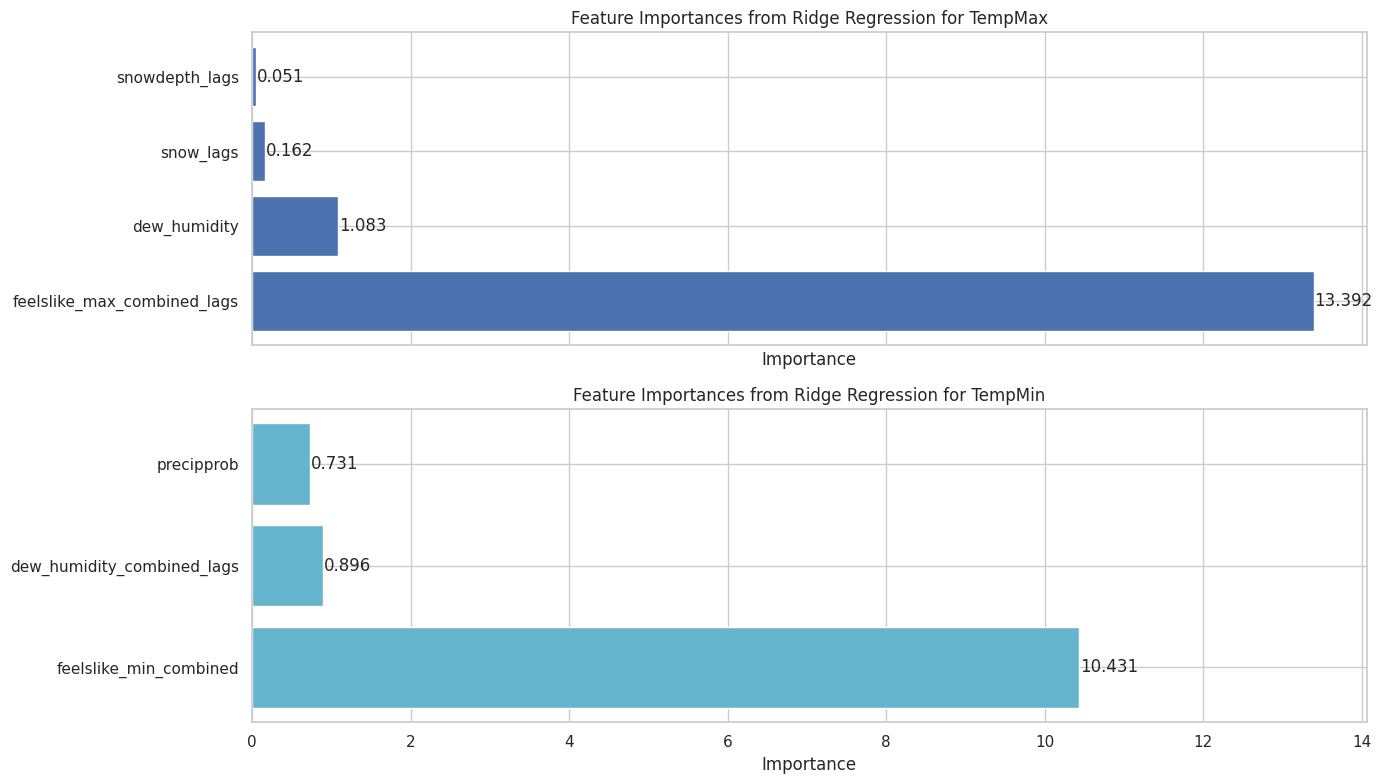

In [3619]:
# Feature importances for tempmax
importances_max = abs(ridge_model_max.coef_)
importance_df_max = pd.DataFrame({
    'Feature': X_train_max.columns,
    'Importance': importances_max
}).sort_values(by='Importance', ascending=False)

# Feature importances for tempmin
importances_min = abs(ridge_model_min.coef_)
importance_df_min = pd.DataFrame({
    'Feature': X_train_min.columns,
    'Importance': importances_min
}).sort_values(by='Importance', ascending=False)

print("Feature Importances from Ridge Regression for tempmax:")
print(importance_df_max)

print("Feature Importances from Ridge Regression for tempmin:")
print(importance_df_min)

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# TempMax Plot
ax1.barh(importance_df_max['Feature'], importance_df_max['Importance'], color=color_pal[0])
ax1.set_title('Feature Importances from Ridge Regression for TempMax')
ax1.set_xlabel('Importance')
for index, value in enumerate(importance_df_max['Importance']):
    ax1.text(value + 0.01, index, f'{value:.3f}', va='center')

# TempMin Plot
ax2.barh(importance_df_min['Feature'], importance_df_min['Importance'], color=color_pal[9])
ax2.set_title('Feature Importances from Ridge Regression for TempMin')
ax2.set_xlabel('Importance')
for index, value in enumerate(importance_df_min['Importance']):
    ax2.text(value + 0.01, index, f'{value:.3f}', va='center')

# Adjust layout
plt.tight_layout()
plt.show()

## Quantile Regression for normality

In [3622]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

# Fit Quantile Regression Model (for median)
quantile_model = QuantileRegressor(quantile=0.5, alpha=0).fit(X_train_max, y_train_max)

# Predictions
y_pred_max = quantile_model.predict(X_val_max)

# RMSE
rmse = np.sqrt(mean_squared_error(y_val_max, y_pred_max))

# Pseudo R²
pseudo_r2 = 1 - (sum((y_val_max - y_pred_max) ** 2) / sum((y_val_max - np.mean(y_val_max)) ** 2))

# Residuals
residuals = y_val_max - y_pred_max

# Durbin-Watson Statistic
dw_stat = durbin_watson(residuals)

# Add a constant (intercept) to the exog array
exog = sm.add_constant(X_val_max)  # Adds a column of ones for the intercept

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, exog)
bp_test_results = {
    'Lagrange multiplier statistic': bp_test[0],
    'p-value': bp_test[1],
    'f-value': bp_test[2],
    'f p-value': bp_test[3]
}

# Output Breusch-Pagan Test results
print(f'Breusch-Pagan Test: {bp_test_results}')

# Shapiro-Wilk Test
shapiro_test = shapiro(residuals)

# Output results
print(f'RMSE for Quantile Regression: {rmse}')
print(f'Pseudo R² for Quantile Regression: {pseudo_r2}')
print(f'Durbin-Watson Statistic: {dw_stat}')
print(f'Breusch-Pagan Test: {bp_test_results}')
print(f'Shapiro-Wilk Test: W={shapiro_test[0]}, p-value={shapiro_test[1]}')



Breusch-Pagan Test: {'Lagrange multiplier statistic': 14.776894701106084, 'p-value': 0.005187040857560715, 'f-value': 3.791256974288165, 'f p-value': 0.004890490573060594}
RMSE for Quantile Regression: 2.0301887260129003
Pseudo R² for Quantile Regression: 0.9260336520555194
Durbin-Watson Statistic: 1.7682813367687564
Breusch-Pagan Test: {'Lagrange multiplier statistic': 14.776894701106084, 'p-value': 0.005187040857560715, 'f-value': 3.791256974288165, 'f p-value': 0.004890490573060594}
Shapiro-Wilk Test: W=0.9789475905196326, p-value=2.0275970813263294e-05


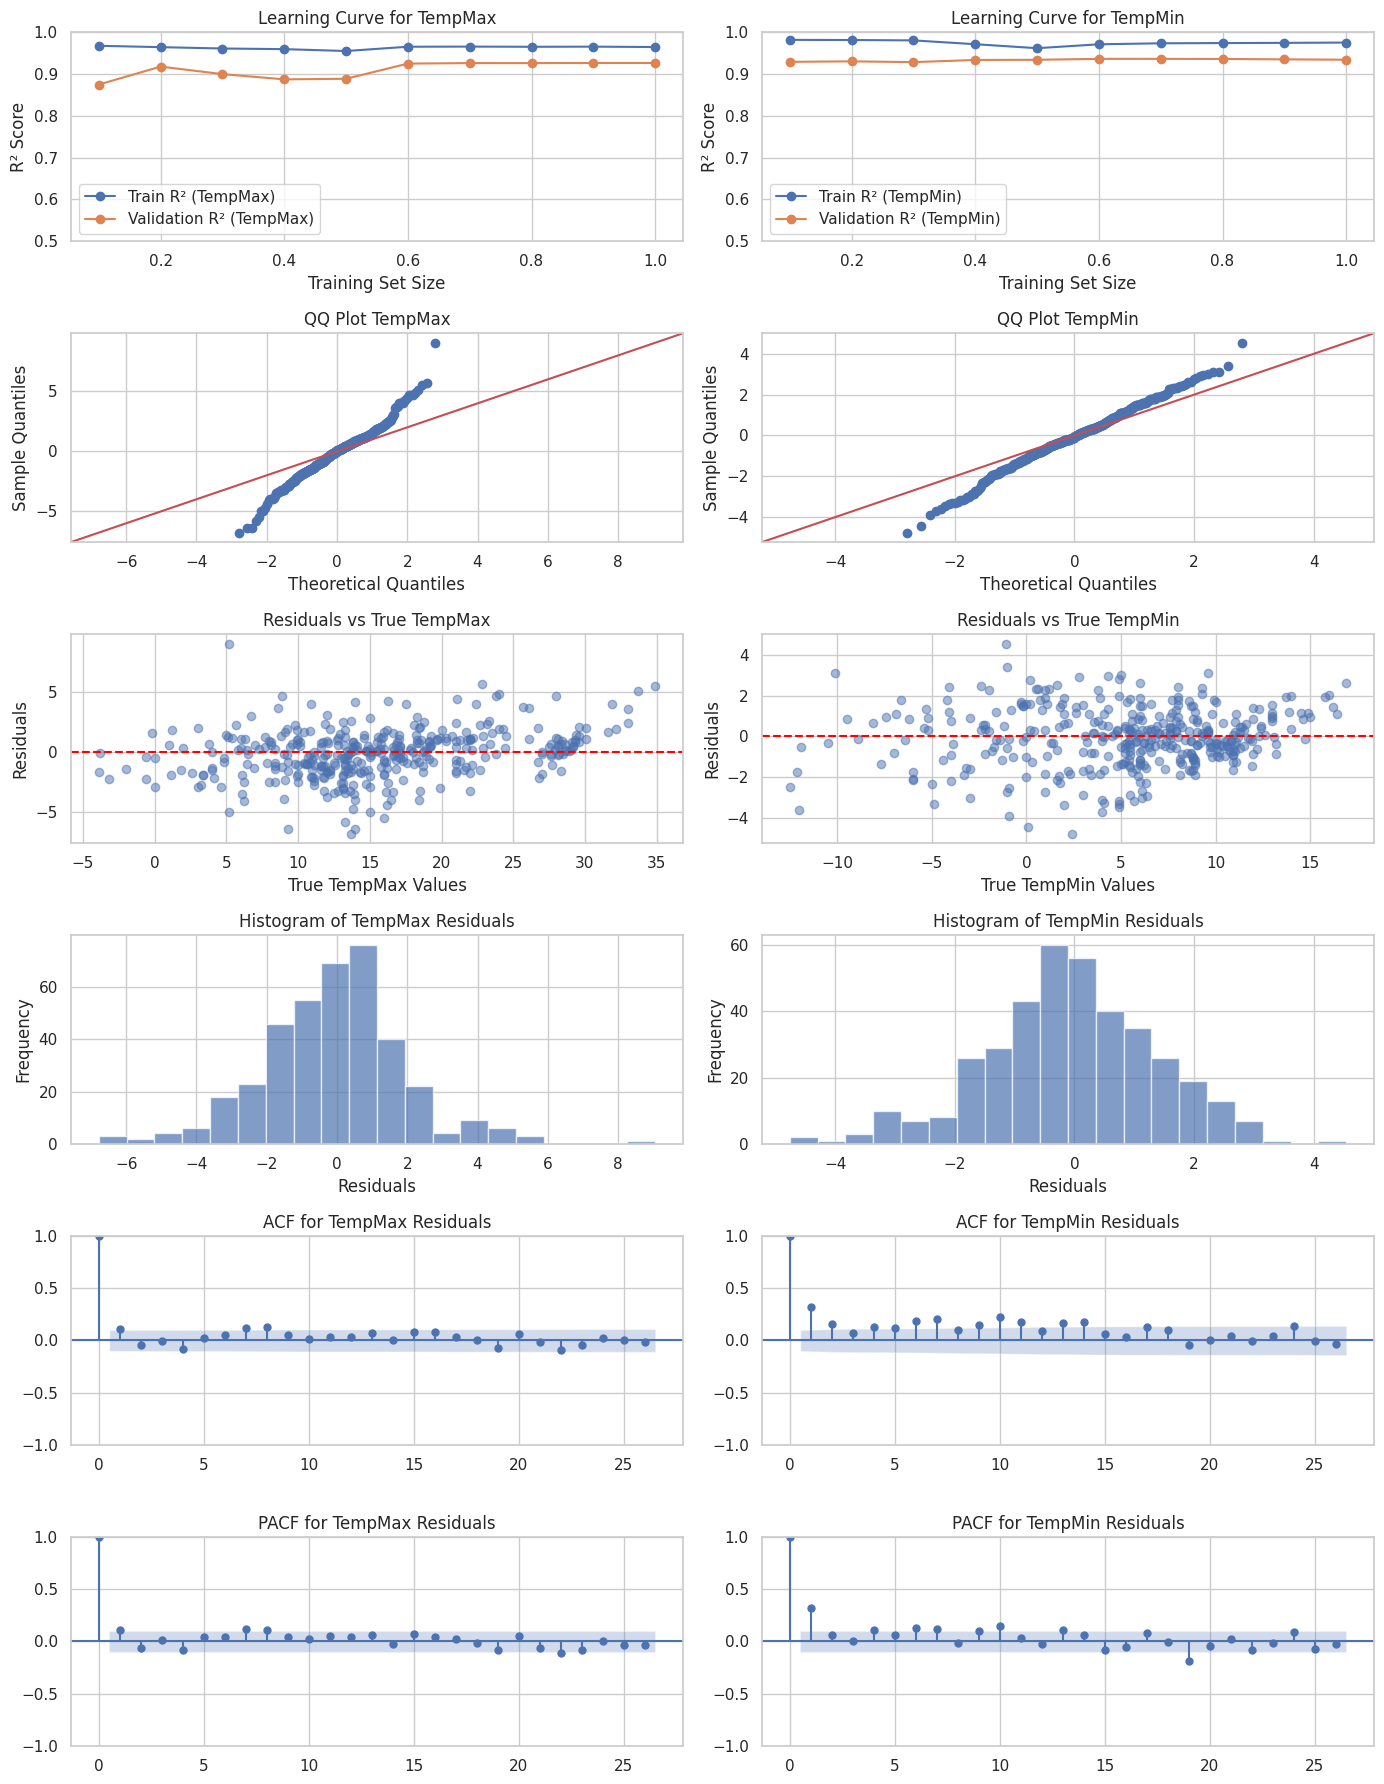

In [3621]:
# List to store results
train_sizes = np.linspace(0.1, 1.0, 10)
train_r2_max = []
val_r2_max = []
train_r2_min = []
val_r2_min = []

for train_size in train_sizes:
    # Calculate the number of samples for the current training subset size
    subset_size_max = int(train_size * len(X_train_max_scaled))
    subset_size_min = int(train_size * len(X_train_min_scaled))

    # Create training subsets
    X_train_max_subset = X_train_max_scaled[:subset_size_max]
    y_train_max_subset = y_train_max.iloc[:subset_size_max]

    X_train_min_subset = X_train_min_scaled[:subset_size_min]
    y_train_min_subset = y_train_min.iloc[:subset_size_min]

    # Initialize and fit the Ridge Regression model
    ridge_model_max = Ridge(alpha=best_alpha_max)
    ridge_model_max.fit(X_train_max_subset, y_train_max_subset)

    ridge_model_min = Ridge(alpha=best_alpha_min)
    ridge_model_min.fit(X_train_min_subset, y_train_min_subset)

    # Predict and evaluate
    y_train_pred_max = ridge_model_max.predict(X_train_max_subset)
    y_val_pred_max = ridge_model_max.predict(X_val_max_scaled)

    y_train_pred_min = ridge_model_min.predict(X_train_min_subset)
    y_val_pred_min = ridge_model_min.predict(X_val_min_scaled)

    # Compute R²
    train_r2_max.append(r2_score(y_train_max_subset, y_train_pred_max))
    val_r2_max.append(r2_score(y_val_max, y_val_pred_max))

    train_r2_min.append(r2_score(y_train_min_subset, y_train_pred_min))
    val_r2_min.append(r2_score(y_val_min, y_val_pred_min))

# Create subplots: 6 rows and 2 columns
fig, ax = plt.subplots(6, 2, figsize=(14, 18))  # Adjust the figsize for better spacing

# Learning Curve for TempMax
ax[0, 0].plot(train_sizes, train_r2_max, label='Train R² (TempMax)', marker='o')
ax[0, 0].plot(train_sizes, val_r2_max, label='Validation R² (TempMax)', marker='o')
ax[0, 0].set_title('Learning Curve for TempMax')
ax[0, 0].set_xlabel('Training Set Size')
ax[0, 0].set_ylabel('R² Score')
ax[0, 0].legend()
ax[0, 0].grid(True)
ax[0, 0].set_ylim(0.5, 1.0)  # Set y-axis limit for TempMax

# Learning Curve for TempMin
ax[0, 1].plot(train_sizes, train_r2_min, label='Train R² (TempMin)', marker='o')
ax[0, 1].plot(train_sizes, val_r2_min, label='Validation R² (TempMin)', marker='o')
ax[0, 1].set_title('Learning Curve for TempMin')
ax[0, 1].set_xlabel('Training Set Size')
ax[0, 1].set_ylabel('R² Score')
ax[0, 1].legend()
ax[0, 1].grid(True)
ax[0, 1].set_ylim(0.5, 1.0)  # Set y-axis limit for TempMin

# QQ Plot for TempMax
sm.qqplot(residuals_max, line='45', ax=ax[1, 0])
ax[1, 0].set_title('QQ Plot TempMax')

# QQ Plot for TempMin
sm.qqplot(residuals_min, line='45', ax=ax[1, 1])
ax[1, 1].set_title('QQ Plot TempMin')

# Scatter Plot for TempMax Residuals vs True Values
ax[2, 0].scatter(y_val_max, residuals_max, alpha=0.5)
ax[2, 0].axhline(0, color='red', linestyle='--')
ax[2, 0].set_xlabel('True TempMax Values')
ax[2, 0].set_ylabel('Residuals')
ax[2, 0].set_title('Residuals vs True TempMax')

# Scatter Plot for TempMin Residuals vs True Values
ax[2, 1].scatter(y_val_min, residuals_min, alpha=0.5)
ax[2, 1].axhline(0, color='red', linestyle='--')
ax[2, 1].set_xlabel('True TempMin Values')
ax[2, 1].set_ylabel('Residuals')
ax[2, 1].set_title('Residuals vs True TempMin')

# Histogram of TempMax Residuals
ax[3, 0].hist(residuals_max, bins=20, alpha=0.7)
ax[3, 0].set_title('Histogram of TempMax Residuals')
ax[3, 0].set_xlabel('Residuals')
ax[3, 0].set_ylabel('Frequency')

# Histogram of TempMin Residuals
ax[3, 1].hist(residuals_min, bins=20, alpha=0.7)
ax[3, 1].set_title('Histogram of TempMin Residuals')
ax[3, 1].set_xlabel('Residuals')
ax[3, 1].set_ylabel('Frequency')

# ACF for TempMax Residuals
plot_acf(residuals_max, ax=ax[4, 0])
ax[4, 0].set_title('ACF for TempMax Residuals')

# ACF for TempMin Residuals
plot_acf(residuals_min, ax=ax[4, 1])
ax[4, 1].set_title('ACF for TempMin Residuals')

# PACF for TempMax Residuals
plot_pacf(residuals_max, ax=ax[5, 0])
ax[5, 0].set_title('PACF for TempMax Residuals')

# PACF for TempMin Residuals
plot_pacf(residuals_min, ax=ax[5, 1])
ax[5, 1].set_title('PACF for TempMin Residuals')

# Adjust layout
plt.tight_layout()
plt.show()
